<a href="https://colab.research.google.com/github/eridanletalis/ds_in_b/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Все выполненные обязательные задания и результаты ниже по блокноту. Также есть ряд вопросов, которые возникли в процессе изучения темы.

feature engineering сначала был выполнен (преобразованием в дамми), но после тетсов catboost решил не выполнять, т.к. у catboost с указанием категриальных данных результаты лучше.

На задание 8 времени не осталось.

Задание 9 не получилось из-за какой-то ошибки, решения так и не нашёл.

In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install causalml

In [ ]:
!pip install catboost

In [4]:
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from catboost import CatBoostClassifier




In [5]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# !pip uninstall causalml 
# !pip install --no-cache-dir -U causalml

In [ ]:
# !git clone https://github.com/uber-common/causalml.git
# !cd causalml
# !ls
# !python setup.py build_ext --inplace
# !python setup.py install


    1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
    там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
    2. сделать разбиение набора данных не тренировочную и тестовую выборки
    3. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
    4. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
    5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
    6. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
    7. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
    8. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево


In [ ]:
#df = pd.read_csv("HW_data.csv")
#df.head()

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import os
#gdrive/MyDrive/Colab Notebooks
os.chdir('gdrive/MyDrive/Colab Notebooks')
#os.listdir()


In [8]:
df = pd.read_csv("HW_data.csv")
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [11]:
df.rename(columns={"offer":"treatment", "conversion":"target"}, inplace=True)
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0  
3         Discount       0  
4  Buy One Get One       0

In [12]:
print(df['treatment'].value_counts())
df['treatment']= df['treatment'].map({'No Offer': '0', 'Buy One Get One':'1', 'Discount':'1'}).astype(int)

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64


In [13]:
df['treatment'].value_counts() # убедились, что отработала нормально замена

1    42694
0    21306
Name: treatment, dtype: int64

In [ ]:
21387 + 21307

42694

In [14]:
df['target'].value_counts() # не сбалансирована

0    54606
1     9394
Name: target, dtype: int64

In [15]:
df['zip_code'].value_counts() # в дамми

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [16]:
df['channel'].value_counts() # в дамми

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [17]:
categorical = ['zip_code', 'channel']


In [ ]:
df.info()

In [19]:
df_dummi = df.copy(deep=True) # для дерева
df_cat = df.copy(deep=True) # для catboost

In [20]:
for cat_colname in df_dummi.select_dtypes(include='object').columns[0:]:
    df_dummi = pd.concat([df_dummi, pd.get_dummies(df_dummi[cat_colname], prefix=cat_colname)], axis=1)

In [21]:
for col in categorical:
    del df_dummi[col]

In [ ]:
# df_dummi.info()

In [23]:
TARGET = 'target'
TREAT = 'treatment'

X = df_dummi.copy(deep=True)
del X[TARGET]
y = df_dummi[TARGET]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=135)

In [25]:
X_train_treat = X_train[TREAT]
del X_train[TREAT]
X_test_treat = X_test[TREAT]
del X_test[TREAT]

In [ ]:
# y.value_counts()[1]/y.value_counts()[0]

0.17203237739442553

In [ ]:
# y_train.value_counts()[1]/y_train.value_counts()[0]

0.17105813467168549

In [ ]:
# y_test.value_counts()[1]/y_test.value_counts()[0]

0.1743119266055046

In [ ]:
# df_dummi.groupby(TREAT)[TARGET].describe()

count      mean       std  min  25%  50%  75%  max
treatment                                                      
0          21306.0  0.106167  0.308059  0.0  0.0  0.0  0.0  1.0
1          42694.0  0.167049  0.373024  0.0  0.0  0.0  0.0  1.0

In [26]:
# sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

In [27]:
# sm = sm.fit(X_train, y_train, X_train_treat)

In [28]:
# uplift_sm = sm.predict(X_test)

In [29]:
# sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test_treat, strategy='by_group', k=0.3)

In [30]:
# sm_score

0.07721128115494313

In [31]:
Xc = df_cat.copy(deep=True)
del Xc[TARGET]
yc = df_cat[TARGET]

In [32]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3, random_state=135)

In [34]:
Xc_train_treat = Xc_train[TREAT]
del Xc_train[TREAT]
Xc_test_treat = Xc_test[TREAT]
del Xc_test[TREAT]

In [36]:
smc = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
smc = smc.fit(Xc_train, yc_train, Xc_train_treat, estimator_fit_params={'cat_features': categorical})
uplift_smc = smc.predict(Xc_test)

In [67]:
models_results = []
tmp_res = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

In [68]:
for k in [0.1, 0.2, 0.3]:
  smc_score = uplift_at_k(y_true=yc_test, uplift=uplift_smc, treatment=Xc_test_treat, strategy='by_group', k=k)
  tmp_res['approach'] = "SoloModel"
  field = 'uplift@' + str(int(k*100)) + '%'
  tmp_res[field] = smc_score

models_results.append(tmp_res)

In [69]:
# models_results

[{'approach': 'SoloModel',
  'uplift@10%': 0.08426656315078893,
  'uplift@20%': 0.08431615064945838,
  'uplift@30%': 0.09105881077712064}]

In [46]:
# for k in [0.1, 0.2, 0.3]:
#   field = 'uplift@' + str(int(k*100)) + '%'
#   models_results['approach'] = "SoloModel"
#   models_results[field] = k * 100


не понятно, как интерпретировать этот скор. Сколько является хорошо, сколько является плохо и к какому резульатату надо стремиться, чтобы было хорошо. Также хотелось бы узнать про различные площади под аплифит кривыми, можно ли с ними работать также, как с обычными площадями под кривыми или нет.

In [62]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
smc_trmnt_preds = smc.trmnt_preds_

In [63]:
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
smc_ctrl_preds = smc.ctrl_preds_

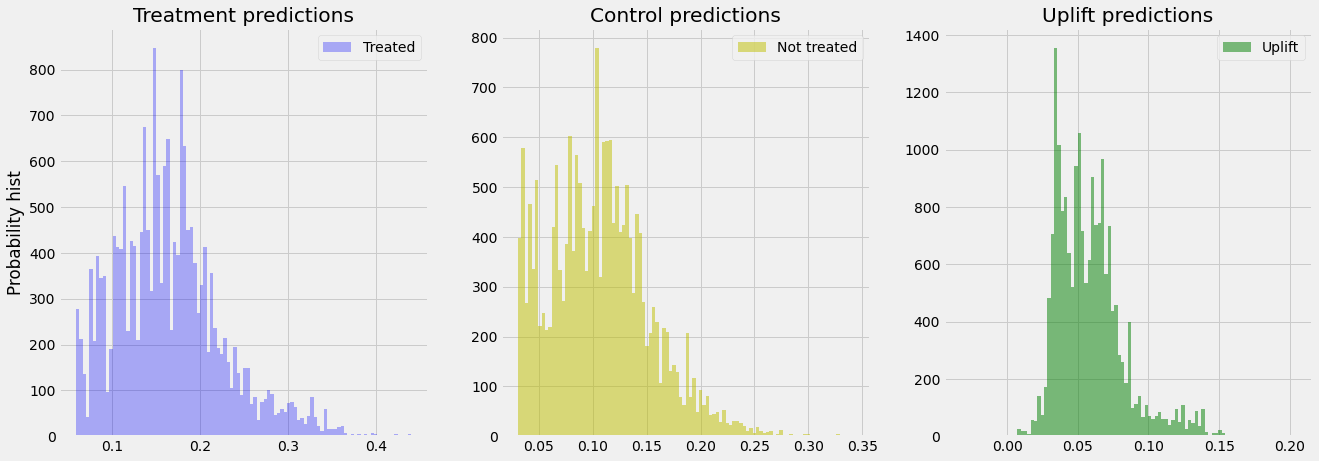

In [64]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=smc_trmnt_preds, ctrl_preds=smc_ctrl_preds);

In [66]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
smc_fi = pd.DataFrame({
    'feature_name': smc.estimator.feature_names_,
    'feature_score': smc.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

smc_fi

feature_name  feature_score
0    is_referral      22.064828
1      treatment      17.765154
2      used_bogo      12.223909
3        recency      11.053213
4       zip_code      10.608353
5  used_discount       9.181721
6        channel       8.817484
7        history       8.285338

In [73]:
ctc = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ctc = ctc.fit(Xc_train, yc_train, Xc_train_treat, estimator_fit_params={'cat_features': categorical})
uplift_ctc = ctc.predict(Xc_test)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [74]:
tmp_res = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}
for k in [0.1, 0.2, 0.3]:
  ct_score = uplift_at_k(y_true=yc_test, uplift=uplift_ctc, treatment=Xc_test_treat, strategy='by_group', k=k)
  tmp_res['approach'] = "ClassTransformation"
  field = 'uplift@' + str(int(k*100)) + '%'
  tmp_res[field] = ct_score

models_results.append(tmp_res)

In [75]:
models_results

[{'approach': 'SoloModel',
  'uplift@10%': 0.08426656315078893,
  'uplift@20%': 0.08431615064945838,
  'uplift@30%': 0.09105881077712064},
 {'approach': 'ClassTransformation',
  'uplift@10%': 0.08979758251362918,
  'uplift@20%': 0.08746738680981708,
  'uplift@30%': 0.07339647311478295}]

In [76]:
ctc_fi = pd.DataFrame({
    'feature_name': ctc.estimator.feature_names_,
    'feature_score': ctc.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ctc_fi

feature_name  feature_score
0      used_bogo      23.311284
1  used_discount      19.703235
2        recency      17.492977
3        history      15.606451
4    is_referral      14.456524
5        channel       5.692581
6       zip_code       3.736949

В двух разных моделях получили разные значимые характеристики. Не совсем понятно, по какой причине так, если данные и классификаторы используются идентичные, кроме того, модель с трансформацией класса практически выводится из SoloModel.

Почему не используем две зависимые модели? Такой подход чем-то не нравится, из опыта больше проблем с ним или как?

Ещё существует вопрос с калибровкой вероятностей. В блокноте Х5, который в доках к аплифит, есть ссылка на этот метод. https://scikit-learn.org/stable/modules/calibration.html

Можно объяснения, когда следует его применять, когда нет?

In [77]:
tmс = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

In [81]:
tmс = tmс.fit(Xc_train, yc_train, Xc_train_treat, 
              estimator_trmnt_fit_params={'cat_features': categorical}, 
              estimator_ctrl_fit_params={'cat_features': categorical})

In [83]:
uplift_tmc = tmс.predict(Xc_test)

In [84]:
tmp_res = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}
for k in [0.1, 0.2, 0.3]:
  tmc_score = uplift_at_k(y_true=yc_test, uplift=uplift_tmc, 
                          treatment=Xc_test_treat, strategy='by_group', k=k)
  tmp_res['approach'] = "TwoModel"
  field = 'uplift@' + str(int(k*100)) + '%'
  tmp_res[field] = tmc_score

models_results.append(tmp_res)

In [85]:
models_results

[{'approach': 'SoloModel',
  'uplift@10%': 0.08426656315078893,
  'uplift@20%': 0.08431615064945838,
  'uplift@30%': 0.09105881077712064},
 {'approach': 'ClassTransformation',
  'uplift@10%': 0.08979758251362918,
  'uplift@20%': 0.08746738680981708,
  'uplift@30%': 0.07339647311478295},
 {'approach': 'TwoModel',
  'uplift@10%': 0.0850441529398265,
  'uplift@20%': 0.09362043918486235,
  'uplift@30%': 0.08319289474219052}]

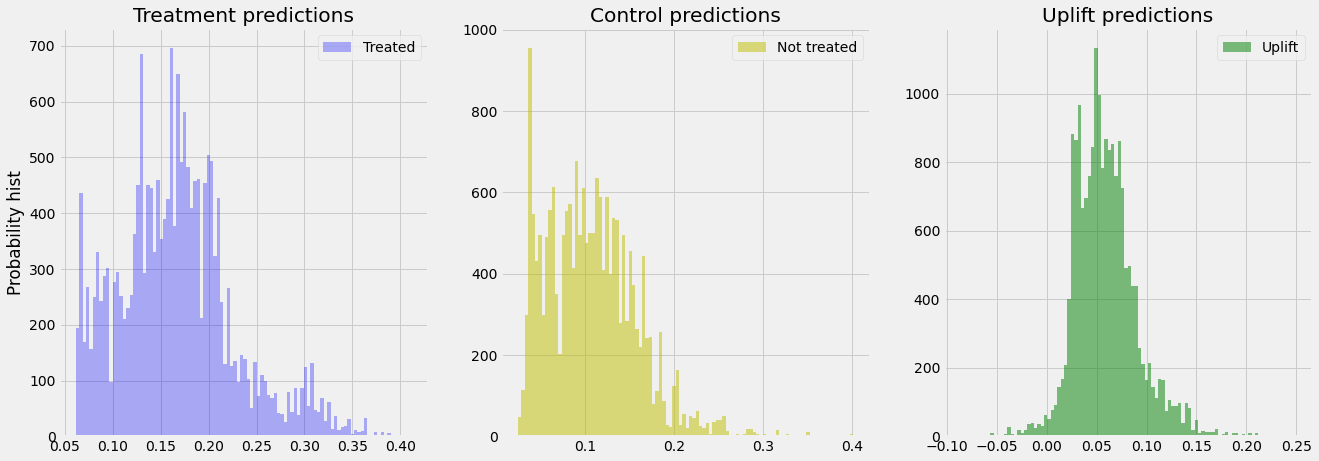

In [89]:
plot_uplift_preds(trmnt_preds=tmс.trmnt_preds_, ctrl_preds=tmс.ctrl_preds_);

In [91]:
tm2_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)

In [92]:
tm2 = tm2_ctrl.fit(Xc_train, yc_train, Xc_train_treat, 
              estimator_trmnt_fit_params={'cat_features': categorical}, 
              estimator_ctrl_fit_params={'cat_features': categorical})

In [93]:
uplift_tm2_ctrl = tm2_ctrl.predict(Xc_test)

In [94]:
tmp_res = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}
for k in [0.1, 0.2, 0.3]:
  tm2_score = uplift_at_k(y_true=yc_test, uplift=uplift_tm2_ctrl, 
                          treatment=Xc_test_treat, strategy='by_group', k=k)
  tmp_res['approach'] = "TwoModelCtrl"
  field = 'uplift@' + str(int(k*100)) + '%'
  tmp_res[field] = tm2_score

models_results.append(tmp_res)

In [95]:
models_results

[{'approach': 'SoloModel',
  'uplift@10%': 0.08426656315078893,
  'uplift@20%': 0.08431615064945838,
  'uplift@30%': 0.09105881077712064},
 {'approach': 'ClassTransformation',
  'uplift@10%': 0.08979758251362918,
  'uplift@20%': 0.08746738680981708,
  'uplift@30%': 0.07339647311478295},
 {'approach': 'TwoModel',
  'uplift@10%': 0.0850441529398265,
  'uplift@20%': 0.09362043918486235,
  'uplift@30%': 0.08319289474219052},
 {'approach': 'TwoModelCtrl',
  'uplift@10%': 0.05533460775050719,
  'uplift@20%': 0.08896524553051399,
  'uplift@30%': 0.08555331991951709}]

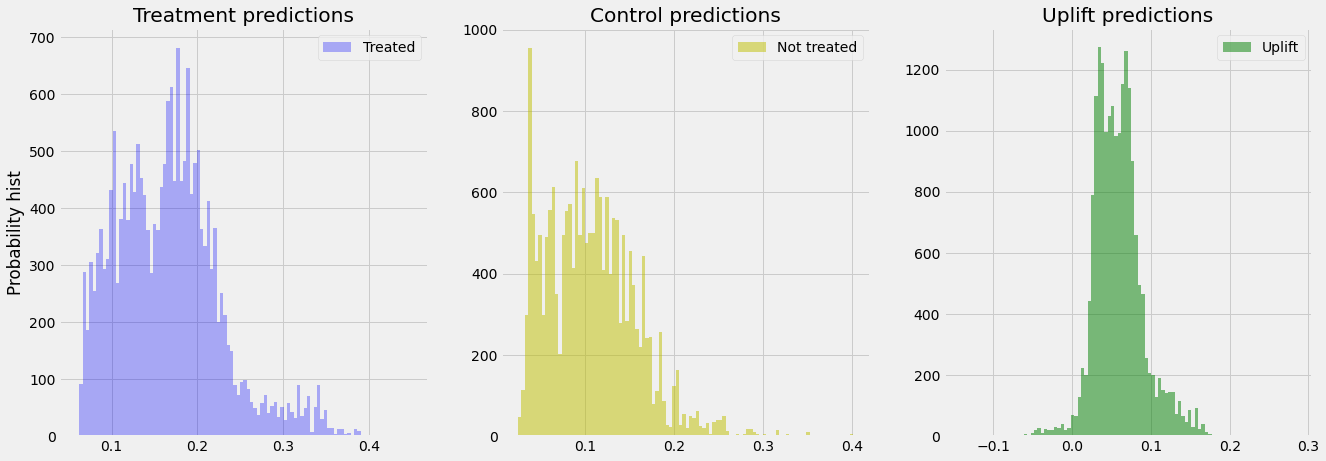

In [96]:
plot_uplift_preds(trmnt_preds=tm2_ctrl.trmnt_preds_, ctrl_preds=tm2_ctrl.ctrl_preds_);

In [178]:
pd.DataFrame(models_results)

approach  uplift@10%  uplift@20%  uplift@30%
0            SoloModel    0.084267    0.084316    0.091059
1  ClassTransformation    0.089798    0.087467    0.073396
2             TwoModel    0.085044    0.093620    0.083193
3         TwoModelCtrl    0.055335    0.088965    0.085553

По 10% лучше работает модель Class Transformation
По 20% лучше работает модель TwoModels
По 30% лучше работает модель SoloModel

На лекции была звучена информация, что лучше обычно работает ClassTransformation. Здесь картина другая. Почему так?


##Строим дерево

In [97]:
X_train_tree = X_train.copy(deep=True)

In [98]:
features = [col for col in X_train_tree]

In [99]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

In [100]:
# дерево без категорий
%%time
uplift_model.fit(X_train_tree.values,
                 treatment=X_train_treat.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

CPU times: user 5.38 s, sys: 16.2 ms, total: 5.4 s
Wall time: 5.41 s


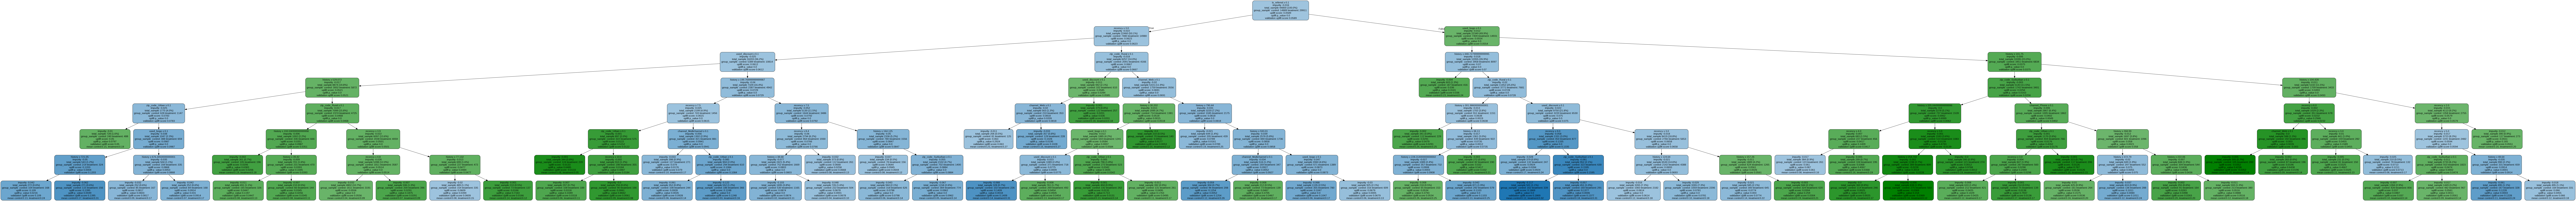

In [101]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Всё дерево слишком обширно, пойдём по левому краю (true-ветки)
Вершиной дерева является условие is_referal. Разделяет на тех, кто пришёл сам, а кто явялется рефералом. По следующим листьям видно, что условие is_referal > 0.1 делит сэмплы примерно поровну. 
Следующим параметром является recently с пороговым значением 3. Этот узел делит пользователей примерно в соотношении 1/3 + 2/3.
Следующий лист used_discount делит пользователей примерно поровну (как по общему числу, так и по целевым группам).
Далее идёт узел history с порогом 529.. (почему-то зелёный). Он, похоже, отсекает пользователей, давно совершавших покупки. Делит неравномерно - большее число уходит в false ветку.
Следующий узел zip code Urban (городской или нет) делится на лист решения (true) и ещё один удел (false). В этом листе не очень большая уверенность в результате, а также небольшая разница между целевыми группами.




Если скор выше, чем базовый, то лист в синих тонах. Если ниже - то в зелёных. Чем темнее цвет листа/узла, тем больше разница между базовым uplifit score и uplifit score текущего узла. 
Что такое базвовый скор, каким должна быть разница в скорах между базовым и текущем? Лучше, когда листья и узлы имеют более тёмный или более светлый оттенок? 
Обратил внимание, что в основном (не всегда), синие листы имеют высокую степень уверенности в результате (низкий p-value) и значимую разницу между mean treatment и mean control.
      # calculate colors for nodes based on uplifts
        minUplift = min(upliftScores)
        maxUplift = max(upliftScores)
        upliftLevels = [(uplift-minUplift)/(maxUplift-minUplift) for uplift in upliftScores]  # min max scaler
        baseUplift = float(decisionTree.summary.get('matchScore'))
        baseUpliftLevel = (baseUplift - minUplift) / (maxUplift - minUplift)  # min max scaler normalization
        white = np.array([255., 255., 255.])
        blue = np.array([31., 119., 180.])
        green = np.array([0., 128., 0.])
        for i, upliftLevel in enumerate(upliftLevels):
            if upliftLevel >= baseUpliftLevel:  # go blue
                color = upliftLevel * blue + (1 - upliftLevel) * white
            else:  # go green
                color = (1 - upliftLevel) * green + upliftLevel * white
            color = [int(c) for c in color]
            upliftScoreToColor[upliftScores[i]] = ('#%2x%2x%2x' % tuple(color)).replace(' ', '0')  # color code
    except Exception as e:
        print(e)


In [151]:
# Дерево с категориями
%%time
uplift_model.fit(Xc_train.values,
                 treatment=Xc_train_treat.map({1: 'treatment', 0: 'control'}).values,
                 y=yc_train)

CPU times: user 5.19 s, sys: 13.5 ms, total: 5.21 s
Wall time: 5.22 s


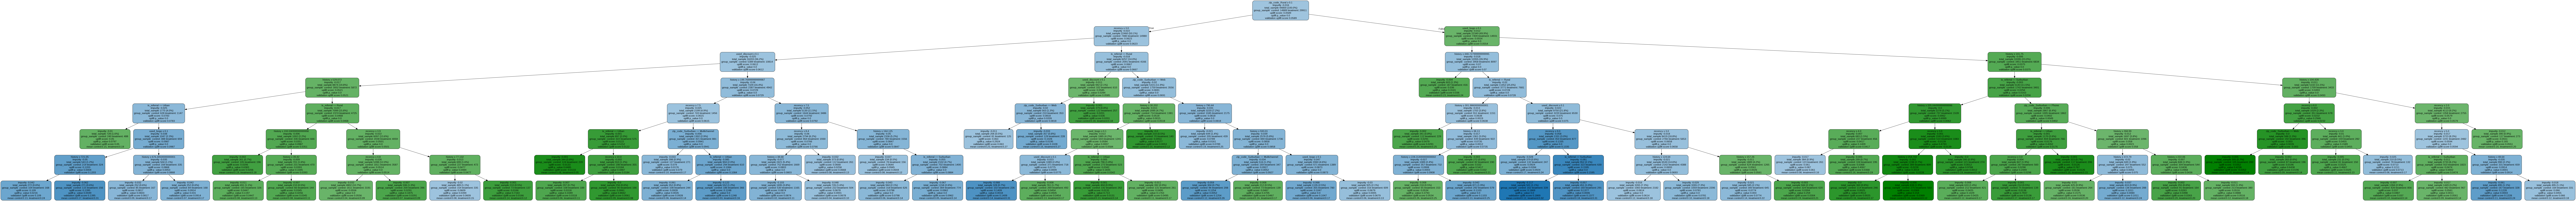

In [152]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [160]:

X_train_tree_tmp = X_train_tree.copy()
X_train_treat_tmp = X_train_treat.copy()
y_train_tmp = y_train.copy()

X_train_tree_tmp['treat'] = X_train_treat_tmp
X_train_tree_tmp['target'] = y_train_tmp

In [170]:
cols = X_train_tree_tmp.columns
list(cols)

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [173]:
import numpy as np
np.array(X_train_tree_tmp.values)

array([[ 11.  ,  43.17,   1.  , ...,   0.  ,   0.  ,   1.  ],
       [  3.  ,  29.99,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  2.  , 194.31,   0.  , ...,   0.  ,   1.  ,   0.  ],
       ...,
       [  6.  , 222.33,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  9.  , 425.25,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [  1.  , 110.32,   0.  , ...,   0.  ,   0.  ,   1.  ]])

In [175]:
pd.DataFrame(np.array(X_train_tree_tmp.values), columns=cols)

recency  history  used_discount  used_bogo  is_referral  \
0         11.0    43.17            1.0        0.0          0.0   
1          3.0    29.99            1.0        0.0          0.0   
2          2.0   194.31            0.0        1.0          1.0   
3         10.0    44.37            0.0        1.0          0.0   
4          1.0   217.47            0.0        1.0          0.0   
...        ...      ...            ...        ...          ...   
44795      2.0    63.79            0.0        1.0          1.0   
44796      4.0    53.16            1.0        0.0          0.0   
44797      6.0   222.33            1.0        0.0          0.0   
44798      9.0   425.25            0.0        1.0          0.0   
44799      1.0   110.32            0.0        1.0          1.0   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
0                 0.0                 0.0             1.0   
1                 0.0                 0.0             1.0   
2                 0.0                 1.0             0.0   
3                 0.0                 1.0             0.0   
4                 1.0                 0.0             0.0   
...               ...                 ...             ...   
44795             0.0                 0.0             1.0   
44796             0.0                 0.0             1.0   
44797             1.0                 0.0             0.0   
44798             0.0                 0.0             1.0   
44799             0.0                 0.0             1.0   

       channel_Multichannel  channel_Phone  channel_Web  
0                       0.0            0.0          1.0  
1                       0.0            1.0          0.0  
2                       0.0            1.0          0.0  
3                       0.0            0.0          1.0  
4                       1.0            0.0          0.0  
...                     ...            ...          ...  
44795                   0.0            1.0          0.0  
44796                   0.0            1.0          0.0  
44797                   0.0            1.0          0.0  
44798                   0.0            1.0          0.0  
44799                   0.0            0.0          1.0  

[44800 rows x 11 columns]

In [166]:
X_train_tree_tmp.values

array([[ 11.  ,  43.17,   1.  , ...,   0.  ,   0.  ,   1.  ],
       [  3.  ,  29.99,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  2.  , 194.31,   0.  , ...,   0.  ,   1.  ,   0.  ],
       ...,
       [  6.  , 222.33,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  9.  , 425.25,   0.  , ...,   0.  ,   1.  ,   0.  ],
       [  1.  , 110.32,   0.  , ...,   0.  ,   0.  ,   1.  ]])

In [163]:
X_train_treat_tmp = X_train_tree_tmp['treat']
del X_train_tree_tmp['treat']
y_train_tmp = X_train_tree_tmp['target']
del X_train_tree_tmp['target']



In [164]:
X_train_tree_tmp

recency  history  used_discount  used_bogo  is_referral  \
24705       11    43.17              1          0            0   
12625        3    29.99              1          0            0   
12791        2   194.31              0          1            1   
61666       10    44.37              0          1            0   
8890         1   217.47              0          1            0   
...        ...      ...            ...        ...          ...   
40316        2    63.79              0          1            1   
8651         4    53.16              1          0            0   
52443        6   222.33              1          0            0   
21691        9   425.25              0          1            0   
55967        1   110.32              0          1            1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
24705               0                   0               1   
12625               0                   0               1   
12791               0                   1               0   
61666               0                   1               0   
8890                1                   0               0   
...               ...                 ...             ...   
40316               0                   0               1   
8651                0                   0               1   
52443               1                   0               0   
21691               0                   0               1   
55967               0                   0               1   

       channel_Multichannel  channel_Phone  channel_Web  
24705                     0              0            1  
12625                     0              1            0  
12791                     0              1            0  
61666                     0              0            1  
8890                      1              0            0  
...                     ...            ...          ...  
40316                     0              1            0  
8651                      0              1            0  
52443                     0              1            0  
21691                     0              1            0  
55967                     0              0            1  

[44800 rows x 11 columns]

In [102]:
uplift_Rmodel = UpliftRandomForestClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

In [155]:
uplift_Rmodel

In [177]:
# Не разобрался, что происходит, почему не работает.

uplift_Rmodel.fit(pd.DataFrame(np.array(X_train_tree_tmp.values), columns=cols).values,
                 treatment=X_train_treat_tmp.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train_tmp)

KeyError: ignored

In [104]:
graphR = uplift_tree_plot(uplift_Rmodel.fitted_uplift_tree, features)
Image(graphR.create_png())

AttributeError: ignored